In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from statsmodels.tsa.ar_model import AutoReg, ar_select_order

plt.rcParams["figure.figsize"] = (15,8)

## Load the residual data from temperature

In [24]:
resi_temp = pd.read_csv('temp_remainder.csv', index_col=0, parse_dates=True)
resi_temp

,remainder
DATE,
1876-01-01,3.068719
1876-01-02,3.368686
1876-01-03,1.168652
1876-01-04,-4.931381
1876-01-05,-8.931414
...,...
2022-03-26,4.318697
2022-03-27,4.618663
2022-03-28,5.718630


In [26]:
resi_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53415 entries, 1876-01-01 to 2022-03-30
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   remainder  53415 non-null  float64
dtypes: float64(1)
memory usage: 834.6 KB


In [27]:
# Plot the data
def plot_remainder(df, title='Remaining Temperature Values after modelling Trend and Seasonality'):
    '''
    Custom plotting function for plotting the temperatture dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('Temperature_C°')
    plt.show()

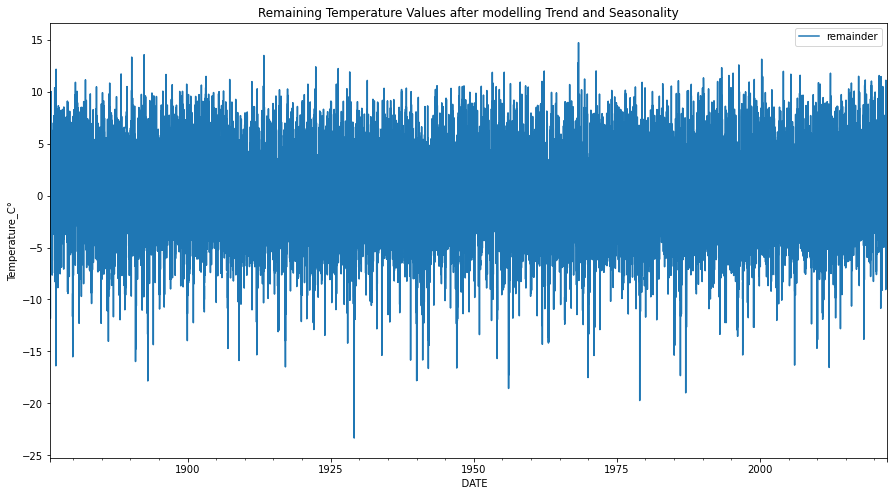

In [28]:
plot_remainder(resi_temp)

## Create the first lag

In [29]:
resi_temp['lag1'] = resi_temp['remainder'].shift(1)
resi_temp.head()

,remainder,lag1
DATE,,
1876-01-01,3.068719,NaN
1876-01-02,3.368686,3.068719
1876-01-03,1.168652,3.368686
1876-01-04,-4.931381,1.168652
1876-01-05,-8.931414,-4.931381


In [30]:
# check correlation 
round(resi_temp[['remainder', 'lag1']].corr(), 3)

,remainder,lag1
remainder,1.000,0.804
lag1,0.804,1.000


<AxesSubplot:xlabel='lag1', ylabel='remainder'>

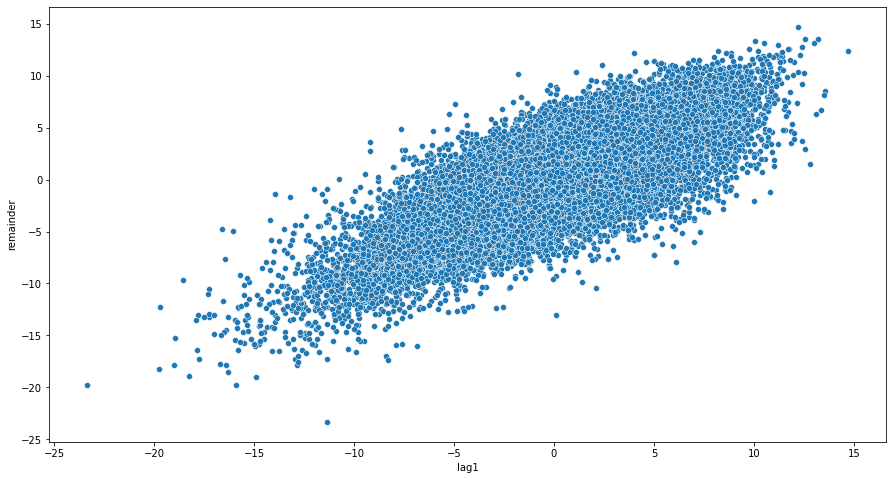

In [31]:
# we could run the scatter plot to check the correlation in a vizual way
sns.scatterplot(x='lag1', y='remainder', data=resi_temp)

## Running an autoregression model (linear regression)

- make sure to drop first row of nan value

In [32]:
# Drop missing values
resi_temp.dropna(inplace=True)
resi_temp.head()

,remainder,lag1
DATE,,
1876-01-02,3.368686,3.068719
1876-01-03,1.168652,3.368686
1876-01-04,-4.931381,1.168652
1876-01-05,-8.931414,-4.931381
1876-01-06,-6.831448,-8.931414


In [33]:
# Assign X and y
X = resi_temp[['lag1']]
y = resi_temp['remainder']

In [34]:
# Create and fit the model
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [35]:
# Create predictions
resi_temp['predictions_ar1'] = m.predict(X)
resi_temp.head()

,remainder,lag1,predictions_ar1
DATE,,,
1876-01-02,3.368686,3.068719,2.466867
1876-01-03,1.168652,3.368686,2.708009
1876-01-04,-4.931381,1.168652,0.939417
1876-01-05,-8.931414,-4.931381,-3.964357
1876-01-06,-6.831448,-8.931414,-7.179956


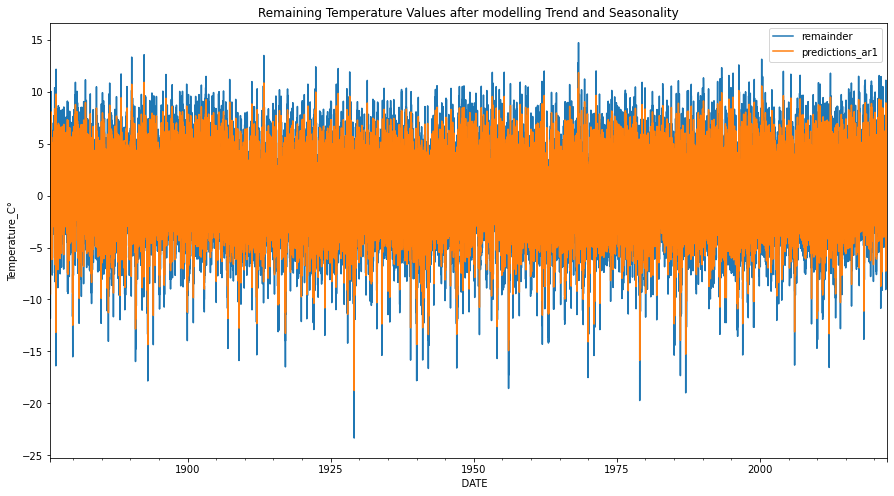

In [36]:
# Plot the original remainder and the prediction
plot_remainder(resi_temp[['remainder', 'predictions_ar1']])

## is there a need for a Lag2

In [37]:
resi_temp['lag2'] = resi_temp['remainder'].shift(2)
resi_temp.head()

,remainder,lag1,predictions_ar1,lag2
DATE,,,,
1876-01-02,3.368686,3.068719,2.466867,NaN
1876-01-03,1.168652,3.368686,2.708009,NaN
1876-01-04,-4.931381,1.168652,0.939417,3.368686
1876-01-05,-8.931414,-4.931381,-3.964357,1.168652
1876-01-06,-6.831448,-8.931414,-7.179956,-4.931381


In [38]:
round(resi_temp[['remainder', 'lag1', 'lag2']].corr(), 3)

,remainder,lag1,lag2
remainder,1.000,0.804,0.599
lag1,0.804,1.000,0.804
lag2,0.599,0.804,1.000


## partial auto-correlation

- One tool to find out how many lags we should include into our Autoregressive Model is to plot the Partial Autocorrelation between different lags. What is the Partial Autocorrelation?

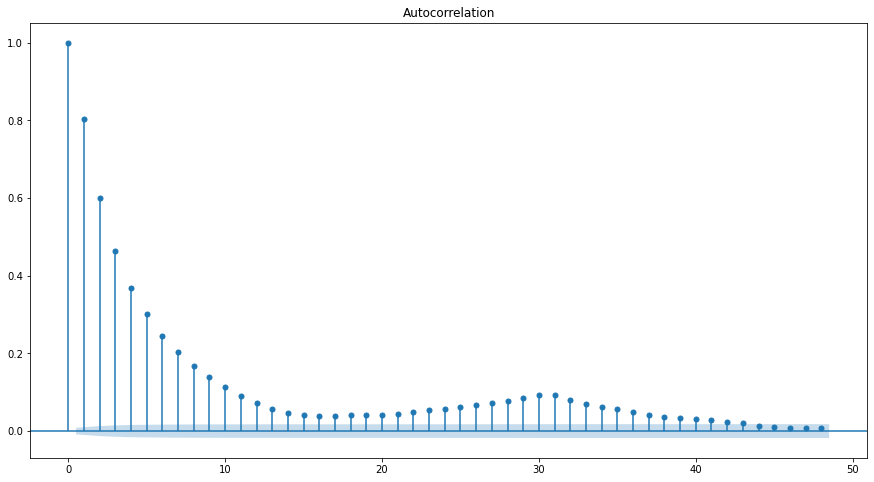

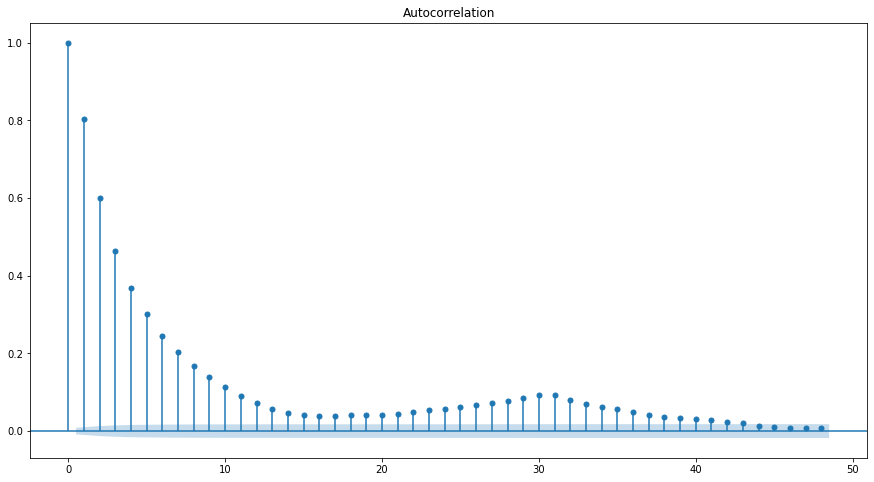

In [39]:
# autorcorrelation function
# includes direct and indirect correlation
plot_acf(resi_temp['remainder']) 

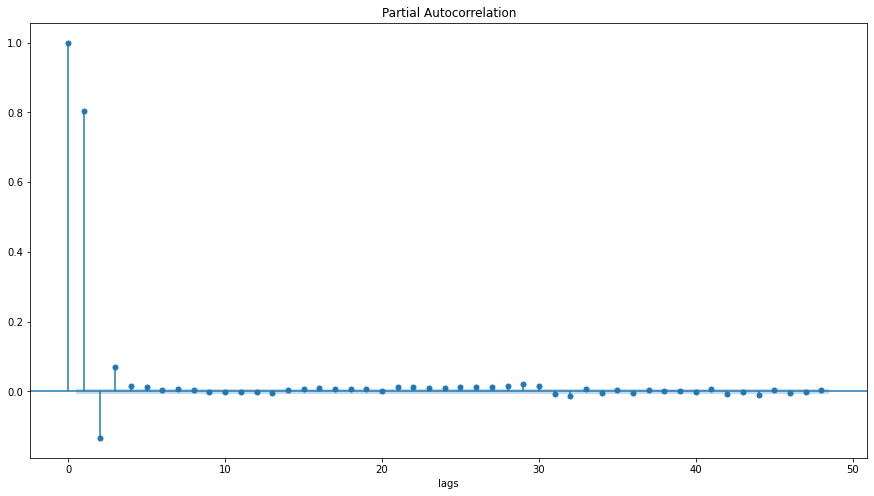

In [40]:
# Statsmodels provides a function called plot_pacf
# includes only direct correlation
# plot partial autocorrelation function
plot_pacf(resi_temp['remainder'], method='ywm')
plt.xlabel('lags');

## statsmodels and ar_select_order

In [17]:
selected_order = ar_select_order(resi_temp['remainder'], maxlag = 12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [18]:
# states the best lag for our data
selected_order.ar_lags

array([1, 2, 3, 4])

## *statsmodels* also has an AutoReg which does a bit of the modelling for you.

In [19]:
ar_model = AutoReg(endog=resi_temp['remainder'], lags=[1, 2, 3, 4]).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [20]:
ar_model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                53414
Model:                     AutoReg(4)   Log Likelihood             -120447.013
Method:               Conditional MLE   S.D. of innovations              2.308
Date:                Fri, 29 Apr 2022   AIC                              1.673
Time:                        15:47:18   BIC                              1.674
Sample:                    01-06-1876   HQIC                             1.673
                         - 03-30-2022                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0001      0.010      0.015      0.988      -0.019       0.020
remainder.L1     0.9192      0.004    212.458      0.000       0.911       0.928
remainder.L2    -0.1933      0.006    -32.913      0.000      -0.205      -0.182
remainder.L3     0.0540      0.006      9.193      0.000       0.042       0.065
remainder.L4     0.0168      0.004      3.873      0.000       0.008       0.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2582           -0.0000j            1.2582           -0.0000
AR.2            1.0134           -2.5027j            2.7001           -0.1888
AR.3            1.0134           +2.5027j            2.7001            0.1888
AR.4           -6.5066           -0.0000j            6.5066           -0.5000
-----------------------------------------------------------------------------
"""

In [45]:
X.lag1

    DATE
1876-01-02    3.068719
1876-01-03    3.368686
1876-01-04    1.168652
1876-01-05   -4.931381
1876-01-06   -8.931414
                ...   
2022-03-26    4.918730
2022-03-27    4.318697
2022-03-28    4.618663
2022-03-29    5.718630
2022-03-30    2.918597
Name: lag1, Length: 53414, dtype: float64

In [51]:
resi_temp['predictions_AutoReg'] = ar_model.predict(start=X.index[0], end=X.index[-1])

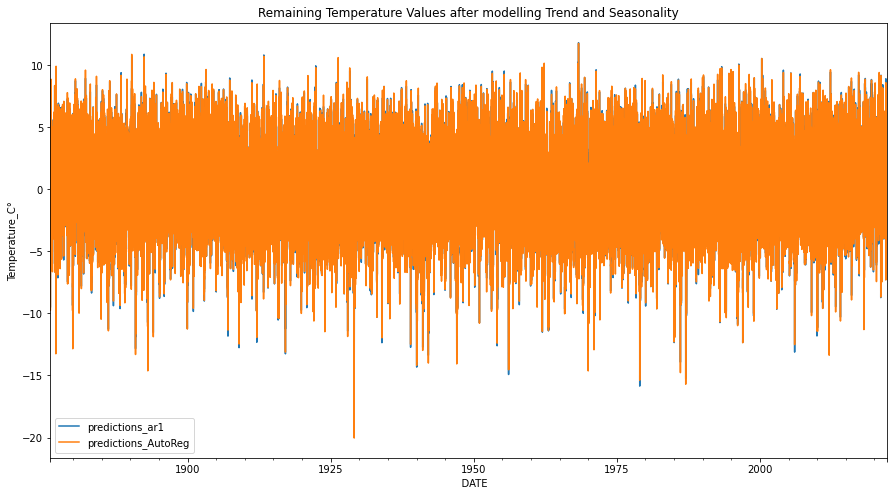

In [55]:
plot_remainder(resi_temp[['predictions_ar1','predictions_AutoReg']])

No handles with labels found to put in legend.


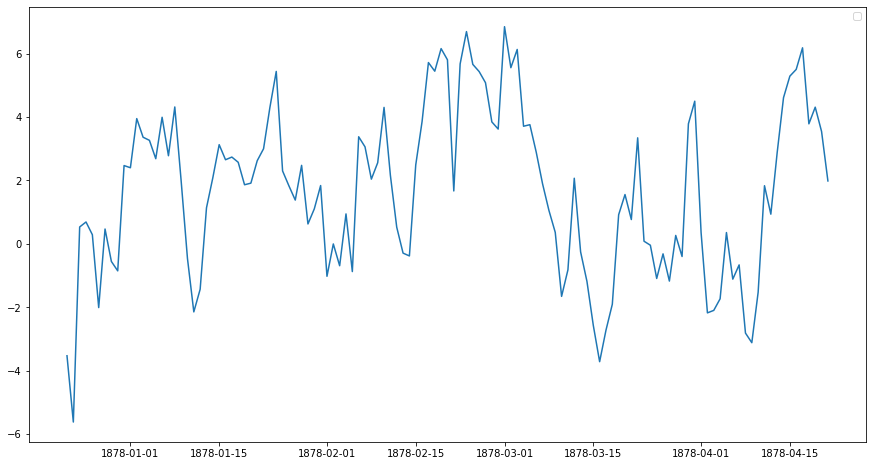

In [50]:
fig = ar_model.plot_predict(720, 840)